In [3]:
import sys
if 'google.colab' in sys.modules:
  %pip install -q stellargraph[demos]==1.2.1

     |████████████████████████████████| 435 kB 4.5 MB/s 
     |████████████████████████████████| 482 kB 40.5 MB/s 
     |████████████████████████████████| 462 kB 57.5 MB/s 
     |████████████████████████████████| 41 kB 541 kB/s 


In [2]:
import pandas as pd
import os

In [4]:
import stellargraph as sg
from stellargraph.mapper import FullBatchNodeGenerator
from stellargraph.layer import GCN

In [6]:
from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import  preprocessing, model_selection
from IPython.display import display, HTML
import matplotlib.pyplot as plt

In [7]:
#Import the Cora dataset
dataset = sg.datasets.Cora()
display(HTML(dataset.description))
G , node_subjects = dataset.load()

In [8]:
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 2708, Edges: 5429

 Node types:
  paper: [2708]
    Features: float32 vector, length 1433
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [5429]
        Weights: all 1 (default)
        Features: none


In [10]:
#Number of categories in the graph
node_subjects.value_counts().to_frame()

,subject
Neural_Networks,818
Probabilistic_Methods,426
Genetic_Algorithms,418
Theory,351
Case_Based,298
Reinforcement_Learning,217
Rule_Learning,180


In [11]:
train_subjects, test_subjects = model_selection.train_test_split(node_subjects, train_size = 140, test_size = None, stratify = node_subjects)
val_subjects, test_subjects = model_selection.train_test_split(test_subjects, train_size = 500, test_size = None, stratify = test_subjects)

In [12]:
train_subjects.value_counts().to_frame()

,subject
Neural_Networks,42
Probabilistic_Methods,22
Genetic_Algorithms,22
Theory,18
Case_Based,16
Reinforcement_Learning,11
Rule_Learning,9


In [13]:
target_encoding = preprocessing.LabelBinarizer()

In [14]:
#Converting data to vector form to pass to GCN
train_targets = target_encoding.fit_transform(train_subjects)
val_targets = target_encoding.transform(val_subjects)
test_targets = target_encoding.transform(test_subjects)

In [15]:
generator = FullBatchNodeGenerator(G, method = "gcn")

Using GCN (local pooling) filters...


In [16]:
train_gen = generator.flow(train_subjects.index, train_targets)

In [19]:
gcn = GCN(layer_sizes=[16, 16], activations=["relu", "relu"], generator=generator, dropout=0.5)

In [20]:
x_inp, x_out = gcn.in_out_tensors()
x_out

<KerasTensor: shape=(1, None, 16) dtype=float32 (created by layer 'gather_indices')>

In [25]:
predictions = layers.Dense(units = train_targets.shape[1], activation = "softmax")(x_out)

In [27]:
model = Model(inputs = x_inp, outputs = predictions)
model.compile(optimizer = optimizers.Adam(learning_rate = 0.01), loss = losses.categorical_crossentropy, metrics = ["acc"])

In [28]:
val_gen = generator.flow(val_subjects.index, val_targets)

In [29]:
from tensorflow.keras.callbacks import EarlyStopping

In [30]:
es_callback = EarlyStopping(monitor="val_acc", patience = 50, restore_best_weights=True)

In [34]:
history = model.fit(train_gen, epochs=200, validation_data = val_gen, verbose = 2, shuffle = False, callbacks=[es_callback])

Epoch 1/200
1/1 - 0s - loss: 0.0698 - acc: 0.9786 - val_loss: 0.7561 - val_acc: 0.8220 - 175ms/epoch - 175ms/step
Epoch 2/200
1/1 - 0s - loss: 0.0822 - acc: 0.9857 - val_loss: 0.7650 - val_acc: 0.8180 - 158ms/epoch - 158ms/step
Epoch 3/200
1/1 - 0s - loss: 0.0453 - acc: 1.0000 - val_loss: 0.7788 - val_acc: 0.8040 - 151ms/epoch - 151ms/step
Epoch 4/200
1/1 - 0s - loss: 0.0363 - acc: 0.9929 - val_loss: 0.8024 - val_acc: 0.8020 - 164ms/epoch - 164ms/step
Epoch 5/200
1/1 - 0s - loss: 0.0244 - acc: 1.0000 - val_loss: 0.8298 - val_acc: 0.8040 - 149ms/epoch - 149ms/step
Epoch 6/200
1/1 - 0s - loss: 0.0485 - acc: 0.9857 - val_loss: 0.8404 - val_acc: 0.8060 - 152ms/epoch - 152ms/step
Epoch 7/200
1/1 - 0s - loss: 0.0530 - acc: 0.9929 - val_loss: 0.8482 - val_acc: 0.8060 - 149ms/epoch - 149ms/step
Epoch 8/200
1/1 - 0s - loss: 0.0807 - acc: 0.9857 - val_loss: 0.8444 - val_acc: 0.8080 - 160ms/epoch - 160ms/step
Epoch 9/200
1/1 - 0s - loss: 0.0612 - acc: 0.9857 - val_loss: 0.8387 - val_acc: 0.8060 -

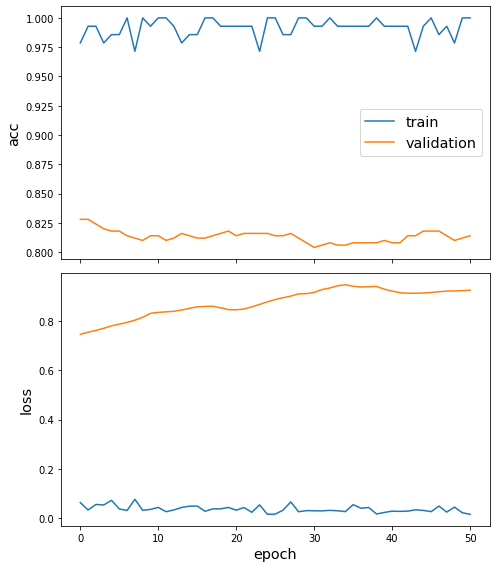

In [33]:
sg.utils.plot_history(history)

In [35]:
test_gen = generator.flow(test_subjects.index, test_targets)

In [37]:
all_nodes = node_subjects.index
all_gen = generator.flow(all_nodes)
all_predictions = model.predict(all_gen)

In [38]:
node_predictions = target_encoding.inverse_transform(all_predictions.squeeze())

In [39]:
df = pd.DataFrame({"Predicted":node_predictions, "True":node_subjects})
df.head(20)

,Predicted,True
31336,Probabilistic_Methods,Neural_Networks
1061127,Rule_Learning,Rule_Learning
1106406,Reinforcement_Learning,Reinforcement_Learning
13195,Reinforcement_Learning,Reinforcement_Learning
37879,Probabilistic_Methods,Probabilistic_Methods
1126012,Probabilistic_Methods,Probabilistic_Methods
1107140,Reinforcement_Learning,Theory
1102850,Neural_Networks,Neural_Networks
31349,Probabilistic_Methods,Neural_Networks
1106418,Theory,Theory


In [ ]:
embedding